<a href="https://colab.research.google.com/github/PristRawal/Cat_Dog_Classification/blob/main/Swin_Unetr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
image_dir = "/content/drive/MyDrive/OASIS_FULL_Dataset/Image"
label_dir = "/content/drive/MyDrive/OASIS_FULL_Dataset/Labels"

In [3]:
lut_path = "/content/drive/MyDrive/Dataset/FreeSurferColorLUT.txt"

In [4]:
!pip install "monai==1.4.1rc1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.5 MB/s eta 0:00:00


In [5]:
import glob
import pandas as pd
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import time


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader, Dataset, MetaTensor
from monai.handlers import (
    MeanDice,
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import (
    first,
    set_determinism,
)


import torch
import torch.nn as nn
import torch.optim as optim

print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.47.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

In [6]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))[:175]
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))[:175]

In [7]:
len(images), len(labels)

(175, 175)

In [8]:
def set_labels(labels_path, num_labels, new_label_path):
  for f in labels_path:
    label = nib.load(label).get_fdata()
    unique_labels = np.unique(label)
    label[label==unique_labels[num_labels:]] = 0
    nib.save(nib.Nifti1Image(label, np.eye(4)), os.join(new_label_path, os.path.basename(f)))
    print(f"Saved {os.path.basename(f)}")

In [9]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




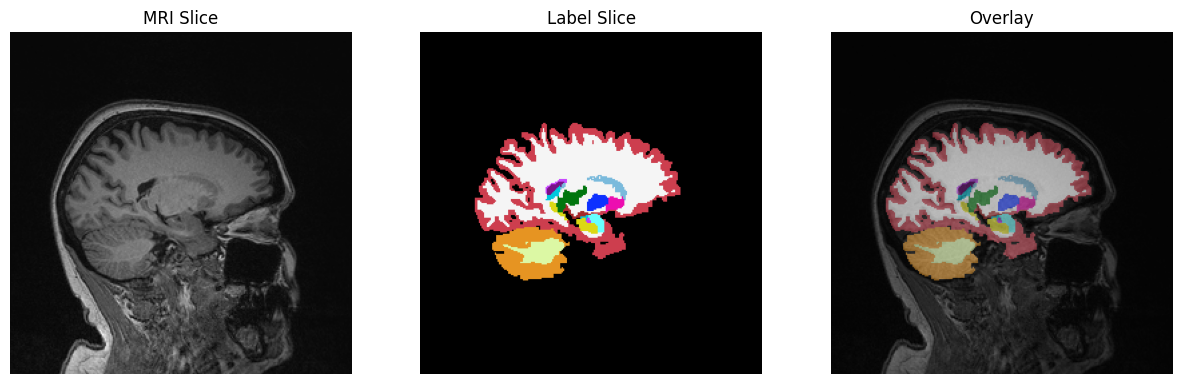

In [ ]:
visualize_image(images[0],labels[0], 110)

In [10]:
def replace_freesurfer_index_with_contiguous(seg):
   label_index=np.unique(seg)
   for items in label_index:
     seg[seg==items]=np.where(label_index==items)[0][0]
   return seg

In [11]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    Resize((128, 128, 128)),
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(replace_freesurfer_index_with_contiguous),
    ToTensor(),
    EnsureChannelFirst(),
    Resize((128, 128, 128), mode="nearest"),
])


In [12]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


In [13]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:150]
val_files   = data_dicts[150:]

In [14]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [15]:
for val_data in val_loader:
    val_inputs, val_labels = val_data[0], val_data[1]
    print(f"Inputs shape:", val_inputs.shape)
    print(f"Labels shape:", val_labels.shape)


Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128, 128])
Labels shape: torch.Size([1, 1, 128, 128, 128])
Inputs shape: torch.Size([1, 1, 128, 128

In [16]:
img_sample, seg_sample = train_ds[0]
print("Image shape:", img_sample.shape)
print("Label shape:", seg_sample.shape)


img_np = img_sample.squeeze().numpy()
seg_np = seg_sample.squeeze().numpy()



Image shape: torch.Size([1, 128, 128, 128])
Label shape: torch.Size([1, 128, 128, 128])


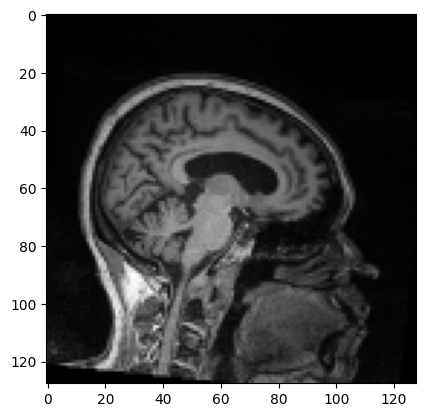

In [17]:
plt.imshow(img_np[60, :, :], cmap="gray")
plt.show()

In [ ]:
num_classes = 45
from monai.networks.nets import SwinUNETR

model = SwinUNETR(
    img_size=(128, 128, 128),
    in_channels=1,
    out_channels=num_classes,
).cuda()

loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [ ]:
from monai.inferers import sliding_window_inference
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


In [ ]:
max_epochs = 50
val_interval = 5

train_loss_list = []
val_dice_list   = []
epoch_list      = []

best_metric = -1
best_metric_epoch = -1

for epoch in range(max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}]")
    model.train()
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")

    # Validation every val_interval epochs
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            val_inputs = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (128, 128, 128)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=[val_labels])
                #print(type(dice_metric))



        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)


        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            #torch.save(model.state_dict(), "/content/drive/MyDrive/best_metric_model_01/02.pth")
            print("   Saved new best model")

print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch [1/50]
  Train loss: 0.9715
Epoch [2/50]
  Train loss: 0.9279
Epoch [3/50]
  Train loss: 0.8368
Epoch [4/50]
  Train loss: 0.7722
Epoch [5/50]
  Train loss: 0.7374
  Validation Dice: 0.2861
   Saved new best model
Epoch [6/50]
  Train loss: 0.7052
Epoch [7/50]
  Train loss: 0.6803
Epoch [8/50]
  Train loss: 0.6649
Epoch [9/50]
  Train loss: 0.6559
Epoch [10/50]
  Train loss: 0.6444
  Validation Dice: 0.3533
   Saved new best model
Epoch [11/50]
  Train loss: 0.6386
Epoch [12/50]
  Train loss: 0.6359
Epoch [13/50]
  Train loss: 0.6327
Epoch [14/50]
  Train loss: 0.6295
Epoch [15/50]
  Train loss: 0.6263
  Validation Dice: 0.3648
   Saved new best model
Epoch [16/50]
  Train loss: 0.6244
Epoch [17/50]
  Train loss: 0.6229
Epoch [18/50]
  Train loss: 0.6218
Epoch [19/50]
  Train loss: 0.6206
Epoch [20/50]
  Train loss: 0.6202
  Validation Dice: 0.3700
   Saved new best model
Epoch [21/50]
  Train loss: 0.6187
Epoch [22/50]
  Train loss: 0.6189
Epoch [23/50]
  Train loss: 0.6168
Epoc